In [6]:
# %pip install xlrd
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_excel("C:/Users/river/OneDrive/Escritorio/Pablo/Iron Hack/Projects/Project Week 2/LabWeek2/CVS File/GSAF5.xls")

# Now we want to clean the dataframe a bit
# First lets have a look at the Dataframe
print(df.shape, '\n')
print(df.nunique(), '\n')

# Then we want to standardize the column names
df.columns = df.columns.str.lower().str.replace(" ","_").str.replace(":", "")
df.rename(columns={"species_":"species"}, inplace=True)

# We can see that there are some weird values in the 'Type' column such as 'Boat', 'Questionable ', 'Unconfirmed'
# We want to merge these values into a single category called 'Under investigation'

# First, we drop the rows where 'Type' and 'Sex' are null
df.dropna(subset=["sex", "type"], inplace=True)

# Then, we replace the values in the 'Type' column
def replace_type(value):
    if isinstance(value, str):
        # Remove white spaces and compare lower-case
        value_clean = value.strip().lower()
        valid_types = ['unprovoked', 'provoked']
        if value_clean not in valid_types:
            return "Under investigation"
        else:
            # Return the standardized value (capitalize first letter)
            return value_clean.capitalize()
    return value

df["type"] = df["type"].apply(replace_type)

# Now we can check the value counts again
print(df["type"].value_counts(), '\n')

# Now we want to clean the 'sex' column in the same way
def replace_sex(value):
    if isinstance(value, str):
        if value[0].lower() == "f":
            return "F"
        else:
            return "M"

df["sex"] = df["sex"].apply(replace_sex)
print(df["sex"].value_counts(), '\n')
print(df['sex'].unique(), '\n')

# Now lets dive into the 'time' column and clean it
# We want to have four unique values with the following criteria:
# 6 am until noon -> Morning
# Noon until 6 pm -> Afternoon
# 6 pm until midnight -> Night
# Midnight until 6 am -> Dawn

# We need to use regex to extract the hour and minutes from the 'time' column
# We will create a function to clean the 'time' column
def time_cleaner(val):
    if pd.isna(val):
        return np.nan # Return NaN for null values
    
    val = str(val).strip().lower() # Convert to string and lower case
    
    # Remove unwanted characters
    val = re.sub(r'[^0-9a-z: ]', '', val) # Keep only alphanumeric characters, colon, and space

    # The previous regex cleans the column to keep only the essential characters needed for time parsing
    # The ^ inside []indicates negation, means "match everything EXCEPT these characters", so we basically removing unwanted punctuation, uppercase letters, and special characters while preserving the useful parts

    # Simple textual cases using any() for efficiency
    if any(word in val for word in ['dawn', 'daybreak', 'sunrise', 'early morning']):
        return 'Dawn'
    if any(word in val for word in ['morning']):
        return 'Morning'
    if any(word in val for word in ['noon', 'midday', 'afternoon', 'after noon', 'mid afternoon', 'late afternoon']):
        return 'Afternoon'
    if any(word in val for word in ['evening', 'dusk', 'sunset', 'night', 'dark']):
        return 'Evening'

    # Numeric time formats using regex to capture hour and optional minutes with or without separators
    # This regex is designed to extract time information from various formats
    match = re.search(r'(\d{1,2})[:h]?(\d{0,2})?', val)
    if match:
        hour = int(match.group(1)) # Extract hour from regex group 1
        minutes = match.group(2) if match.group(2) else '00' # Extract minutes from regex group 2 if available

        # 4 digits format without separator (ex: 1530)
        if len(val) >= 4 and val[:4].isdigit(): # Check if first 4 characters are digits
            hour = int(val[:2]) # First two digits are hour
            minutes = val[2:4] # Last two digits are minutes

        # Adjust hour if minutes are superior to 45
        if minutes and minutes.isdigit() and int(minutes) > 45: # If minutes are greater than 45, round up the hour
            hour += 1
        hour = hour % 24  # Ensure hour is within 0-23

        # Convert in 4 periods of the day
        if 5 <= hour < 11:
            return 'Morning'
        elif 11 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 23:
            return 'Evening'
        else:
            return 'Dawn'

    # If nothing matches, return NaN
    return np.nan

# We apply the function to the 'time' column
df['time'] = df['time'].apply(time_cleaner)

# To check the result
print(df['time'].value_counts(dropna=False))

# # Now we want to drop the columns that are not useful for our analysis
df = df.drop(df.columns[[7, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1, inplace=False)
# # We are droping time column because we created a new column 'time_clean' with the cleaned values
# # We did drop the name column because of the data privacy policy in some countries
df.head()

# Pablo Development : Now we want to clean the 'species' column

def classify_species(text): # Function to classify shark species into broader categories
    if isinstance(text, str):
        text = text.lower().strip()
    else:
        return "Unknown"

    if "white" in text:
        return "White Shark"
    elif "tiger" in text:
        return "Tiger Shark"
    elif "bull" in text:
        return "Bull Shark"
    elif "hammer" in text:
        return "Hammerhead Shark"
    elif "nurse" in text:
        return "Nurse Shark"
    elif "reef" in text:
        return "Reef Shark"
    else:
        return "Unknown"

df['species'] = df['species'].apply(classify_species) # Apply the classification function to the 'species' column

# To check the result
print(df['species'].value_counts(dropna=False))

loc = df['location'].astype(str)

loc_clean = (loc
    .str.replace(r'\(.*?\)', ' ', regex=True)      # remove () and content 
    .str.replace(r'\[.*?\]', ' ', regex=True)      # remove brackets and content
    .str.replace(r'[/;|]', ',', regex=True)        # remove other separators
    .str.replace(r'\s+', ' ', regex=True)          # remove spaces
    .str.strip()
    .str.replace(r'\s*,\s*', ', ', regex=True)     # normalice comas with one space
    .str.strip(', ')                               # eliminate floating comas
)

loc_clean = loc_clean.replace({'': np.nan, 'nan': np.nan, 'none': np.nan, '?': np.nan,}) # NaN real

loc_clean = loc_clean.apply(lambda s: s.title() if isinstance(s, str) else s) # Title Case: If its no number or nan

df['location'] = loc_clean

display(df.head())

(7045, 23) 

Date              6089
Year               261
Type                13
Country            247
State              937
Location          4595
Activity          1606
Name              5770
Sex                 10
Age                250
Injury            4162
Fatal Y/N           12
Time               460
Species           1724
Source            5384
pdf               6789
href formula      6784
href              6776
Case Number       6777
Case Number.1     6775
original order    6797
Unnamed: 21          1
Unnamed: 22          2
dtype: int64 

type
Unprovoked             5032
Under investigation     834
Provoked                582
Name: count, dtype: int64 

sex
M    5645
F     803
Name: count, dtype: int64 

['M' 'F'] 

time
NaN          3128
Afternoon    2105
Morning       766
Evening       394
Dawn           55
Name: count, dtype: int64
species
Unknown             5005
White Shark          665
Tiger Shark          323
Bull Shark           223
Nurse Shark          108
Reef Sha

,date,year,type,country,state,location,activity,sex,age,injury,fatal_y/n,time,species
0,6th September,2025.0,Unprovoked,Australia,NSW,Long Reef Sydney,Surfing,M,57,Both legs and arm severed,Y,Morning,White Shark
1,1st September,2025.0,Unprovoked,USA,Florida,Horseshoe Reef Key Largo,Snorkeling,M,8,Bite to leg,N,Afternoon,Unknown
2,30th August,2025.0,Unprovoked,USA,Texas,Galveston,Swimming,F,8,Bite to leg,N,NaN,Unknown
3,18th August,2025.0,Unprovoked,Australia,NSW,Cabarita Beach,Surfing,M,?,None sustained board severly damaged,N,Morning,White Shark
4,17th August,2025.0,Unprovoked,Bahamas,Atlantic Ocean near Big Grand Cay,North Of Grand Bahama Near Freeport,Spearfishing,M,63,Severe injuries no detail,N,Afternoon,Unknown


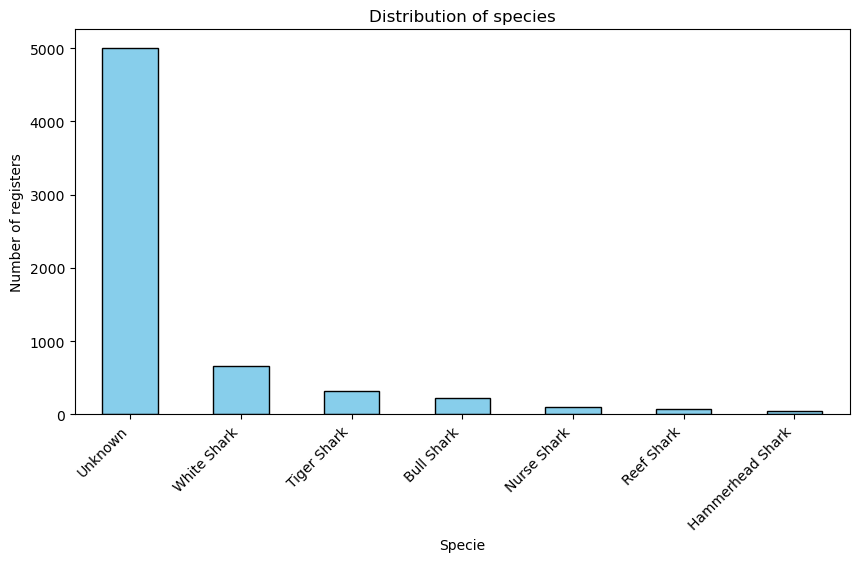

In [7]:
counts = df['species'].value_counts() # Frequency by category

counts.plot(kind='bar', figsize=(10,5), color='skyblue', edgecolor='black') # Bar Graphic

plt.title("Distribution of species")
plt.xlabel("Specie")
plt.ylabel("Number of registers")
plt.xticks(rotation=45, ha='right')
plt.show()


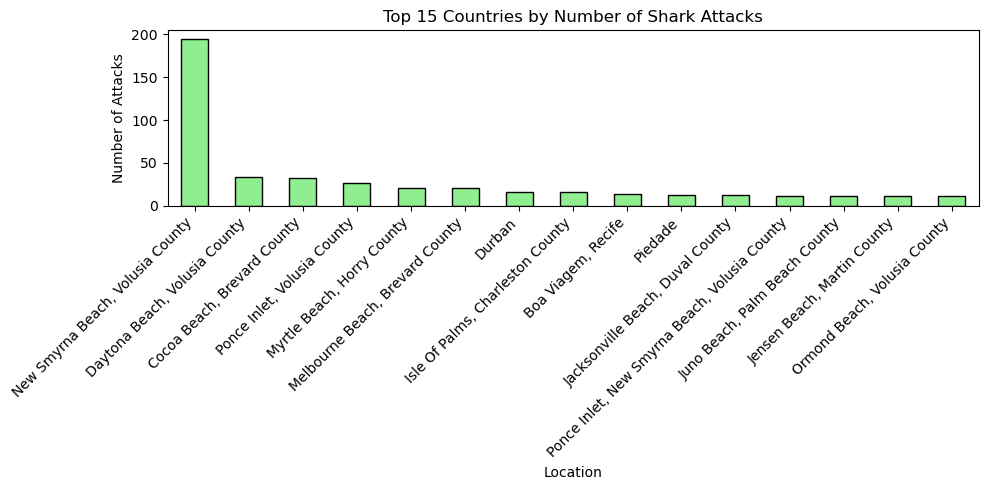

In [8]:
counts_location = df['location'].value_counts().head(15)

counts_location.plot(kind='bar', figsize=(10,5), color='lightgreen', edgecolor='black')

plt.title("Top 15 Countries by Number of Shark Attacks")
plt.xlabel("Location")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [9]:
df[['time']].describe()

,time
count,3320
unique,4
top,Afternoon
freq,2105


In [10]:
df[['sex']].describe()

,sex
count,6448
unique,2
top,M
freq,5645


In [11]:
df[["time"]].describe()

,time
count,3320
unique,4
top,Afternoon
freq,2105


In [12]:
# We want to display the three columns together but only with the null values in 'time'
our_analysis = df[['sex', 'type', 'time']][df['time'].isnull()]
display(our_analysis.value_counts(dropna=False))

sex  type                 time
M    Unprovoked           NaN     1959
     Under investigation  NaN      517
     Provoked             NaN      361
F    Unprovoked           NaN      220
     Under investigation  NaN       55
     Provoked             NaN       16
Name: count, dtype: int64